In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import cddm_data_simulation as cds
import boundary_functions as bf

# Set styles
sns.set(style = "white")

In [2]:
from platform import python_version

print(python_version())

3.7.4


In [189]:
# Plot bound
# Mean posterior predictives

# ORNSTEIN DOESNT WORK FOR NOW....
def bgn_boundary_posterior_plot(params = [],
                                cols = 3,
                                model = 'weibull_cdf',
                                max_t = 10,
                                show = True,
                                save = False,
                                y_limh = 2.2,
                                y_liml = -2.2):
    
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(1, 1, 
                           figsize = (8, 8), 
                           sharex = False, 
                           sharey = False)
   # my_suptitle = fig.suptitle(title + model, fontsize = 20)
    sns.despine(right = True)
    
    t_s = np.arange(0, max_t, 0.01)
    ax.set_xlim(0, max_t)
#     y_limh = 3
#     y_liml = -3
    ax.set_ylim(y_liml, y_limh)
    # Run simulations and add histograms
    # True params
    if model == 'angle':
        ndt = params[3]
        out = cds.ddm_flexbound(v = params[0],
                                a = params[1],
                                w = params[2],
                                ndt = ndt,
                                s = 1,
                                delta_t = 0.001, 
                                max_t = 20,
                                n_samples = 20000,
                                print_info = False,
                                boundary_fun = bf.angle,
                                boundary_multiplicative = False,
                                boundary_params = {'theta': params[4]})

    if model == 'weibull_cdf':
        ndt = params[3]
        out = cds.ddm_flexbound(v = params[0],
                                a = params[1],
                                w = params[2],
                                ndt = ndt,
                                s = 1,
                                delta_t = 0.001, 
                                max_t = 20,
                                n_samples = 20000,
                                print_info = False,
                                boundary_fun = bf.weibull_cdf,
                                boundary_multiplicative = True,
                                boundary_params = {'alpha': params[4],
                                                   'beta': params[5]})
        
    if model == 'ddm':
        ndt = params[3]
        out = cds.ddm_flexbound(v = params[0],
                                a = params[1],
                                w = params[2],
                                ndt = ndt,
                                s = 1,
                                delta_t = 0.001,
                                max_t = 20,
                                n_samples = 20000,
                                print_info = False,
                                boundary_fun = bf.constant,
                                boundary_multiplicative = True,
                                boundary_params = {})
    
    if model == 'ornstein':
        ndt = params[4]
        out = cds.ornstein_uhlenbeck(v = params[0],
                                     a = params[1],
                                     w = params[2],
                                     g = params[3],
                                     ndt = ndt,
                                     s = 1,
                                     delta_t = 0.001,
                                     max_t = 20,
                                     n_samples = 20000,
                                     print_info = False,
                                     boundary_fun = bf.constant,
                                     boundary_multiplicative = True,
                                     boundary_params = {}
                                     )
    
    tmp_true = np.concatenate([out[0], out[1]], axis = 1)
    choice_p_up = np.sum(tmp_true[:, 1] == 1) / 20000
    print('p up: ', choice_p_up)
    
    #ax.set_ylim(-4, 2)
    ax_tmp = ax.twinx()
    ax_tmp.set_ylim(y_liml - params[1] -0.1, y_limh - params[1] - 0.1)
    ax_tmp.set_yticks([])
    
    counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                bins = np.linspace(0, 10, 100))
    
    counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                  bins = np.linspace(0, 10, 100),
                                  density = True)
    print(counts_2)
    ax_tmp.hist(bins[:-1], 
                bins, 
                weights = choice_p_up * counts_2,
                alpha = 0.2, 
                color = 'black',
                edgecolor = 'none',
                zorder = -1)
    
    ax_tmp = ax.twinx()
    ax_tmp.set_ylim(y_limh - params[1] - 0.1,y_liml - params[1] - 0.1)
    ax_tmp.set_yticks([])
    
    counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                bins = np.linspace(0, 10, 100))
    
    counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                  bins = np.linspace(0, 10, 100),
                                  density = True)
    ax_tmp.hist(bins[:-1], 
                bins, 
                weights = (1 - choice_p_up) * counts_2,
                alpha = 0.2, 
                color = 'black',
                edgecolor = 'none',
                zorder = -1)
    
    # Plot true data  
    if model == 'weibull_cdf':
        b = params[1] * bf.weibull_cdf(t = t_s, 
                                       alpha = params[4],
                                       beta = params[5])
    if model == 'angle':
        b = np.maximum(params[1] + bf.angle(t = t_s, theta = params[4]), 0)
        
    if model == 'ddm' or model == 'ornstein':
        b = np.zeros(len(t_s))
        
        cnt = 0
        for t_i in t_s:
            b[cnt] = params[1] * bf.constant(t = t_i)
            cnt += 1
        print(b)

    start_point_tmp = - params[1] + \
                      (2 * params[1] * params[2])
    slope_tmp = params[0]
    
    for i in range(len(t_s)):
        if model != 'ornstein':
            #print('passed')
            if (start_point_tmp + (slope_tmp * t_s[i])) > b[i]:
                maxid = i
                print('maxid: ', maxid)
                break
        else:
            if (start_point_tmp + (slope_tmp * t_s[i])) > b[i]:
                maxid = i
                print('maxid: ', maxid)
                break

    ax.plot(t_s + ndt, b, 'black', 
            t_s + ndt, -b, 'black', 
            alpha = 1,
            linewidth = 3,
            zorder = 1000)
    
    if model == 'ornstein':
        # start_point_tmp * np.exp( - params[3] * t_s[:maxid]) + slope_tmp * (1 - np.exp( - params[3] * t_s[:maxid]))
        ax.plot(t_s[:maxid] + ndt, 
                start_point_tmp + slope_tmp * (1 - np.exp( - params[3] * t_s[:maxid])), 
                'black', 
                alpha = 1, 
                linewidth = 3, 
                zorder = 1000)
    else:
        ax.plot(t_s[:maxid] + ndt, 
                start_point_tmp + (slope_tmp * t_s[:maxid]),
                'black',
                alpha = 1,
                linewidth = 3,
                zorder = 1000)
        
    ax.set_zorder(ax_tmp.get_zorder() + 1)
    ax.patch.set_visible(False)
    print('passed through')

    #ax[row_tmp, col_tmp].legend(labels = [model, 'bg_stn'], fontsize = 20)
    ax.set_xlabel('rt', 
                  fontsize = 20);
    ax.set_ylabel('', 
                  fontsize = 20);
    ax.set_title(model,
                 fontsize = 20)
    ax.tick_params(axis = 'y', 
                   size = 20)
    ax.tick_params(axis = 'x', 
                   size = 20)
    
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    if save:
        plt.savefig(os.getcwd() + '/figures/' + figure_name + model,
                    dpi = 150, 
                    transparent = False,
                    bbox_inches = 'tight',
                    bbox_extra_artists = [my_suptitle])
    if show:
        return plt.show()

p up:  0.73065
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.77478957e-04 1.30075960e-01 4.87107370e-01
 7.05255594e-01 8.21104496e-01 8.46848696e-01 8.28556765e-01
 8.08232396e-01 7.71648532e-01 7.09320468e-01 6.42250051e-01
 5.79244508e-01 5.26401150e-01 4.42393759e-01 4.15294601e-01
 3.27222336e-01 2.66926709e-01 2.16793266e-01 1.53110244e-01
 9.48470540e-02 6.77478957e-02 3.86163006e-02 1.42270581e-02
 2.70991583e-03 2.70991583e-03 6.77478957e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000000

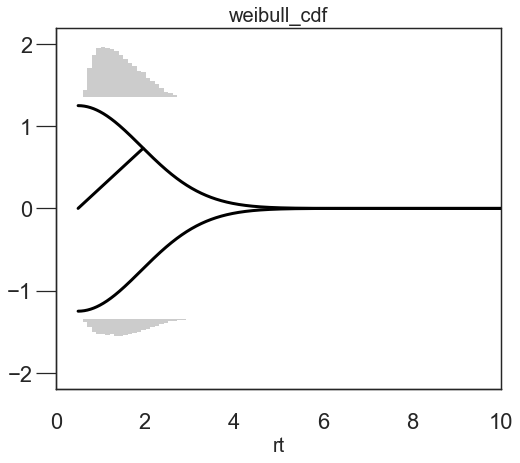

In [190]:
bgn_boundary_posterior_plot(params = [0.5, 1.25, 0.5, 0.5, 2, 2],
                            model = 'weibull_cdf',
                            max_t = 10,
                            show = True,
                            save = False)

p up:  0.74045
[0.         0.         0.         0.         0.         0.00200554
 0.14840975 0.50004727 0.70327504 0.84098859 0.83296644 0.79486123
 0.71129718 0.66450132 0.61168884 0.55152272 0.50138429 0.42851644
 0.37102438 0.32155446 0.31954892 0.25604025 0.2212776  0.19787967
 0.16445405 0.13905058 0.11698967 0.09827132 0.0862381  0.06284016
 0.06551421 0.04077926 0.02941455 0.03543116 0.02406645 0.01938686
 0.01002769 0.00601661 0.00869066 0.00334256 0.00467959 0.00200554
 0.00133702 0.00133702 0.00133702 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

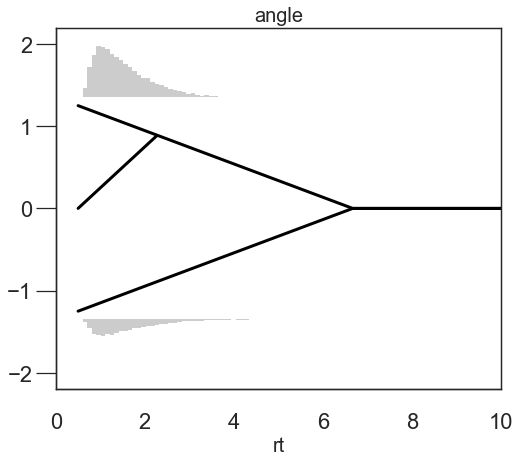

In [191]:
bgn_boundary_posterior_plot(params = [0.5, 1.25, 0.5, 0.5, 0.2],
                            model = 'angle',
                            max_t = 10,
                            show = True,
                            save = False)

p up:  0.78435
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.26251355e-03 1.16782503e-01 3.99585538e-01
 5.65606070e-01 6.28100491e-01 6.41988140e-01 6.36306829e-01
 5.95275139e-01 5.22680610e-01 5.04374163e-01 4.53873621e-01
 4.22942039e-01 3.90747944e-01 3.65497673e-01 3.30147293e-01
 2.90378116e-01 2.64496589e-01 2.40508831e-01 2.23464898e-01
 2.12733533e-01 1.73595613e-01 1.74858127e-01 1.43926545e-01
 1.35720207e-01 1.32563923e-01 1.33195179e-01 1.07944908e-01
 1.01001084e-01 1.00369827e-01 8.14321240e-02 6.81757317e-02
 6.69132181e-02 5.30255691e-02 4.86067717e-02 4.92380284e-02
 4.22942039e-02 4.67130013e-02 3.59816362e-02 3.09315820e-02
 3.09315820e-02 3.03003252e-02 2.77752981e-02 2.71440413e-02
 2.14627303e-02 1.38876490e-02 2.02002168e-02 1.45189058e-02
 1.07313652e-02 1.51501626e-02 1.51501626e-02 1.07313652e-02
 1.57814194e-02 1.07313652e-02 7.57508130e-03 8.20633807e-03
 6.94382452e-03 6.31256775e-03 7.57508130e-03 4.41879742e-03
 3.156283

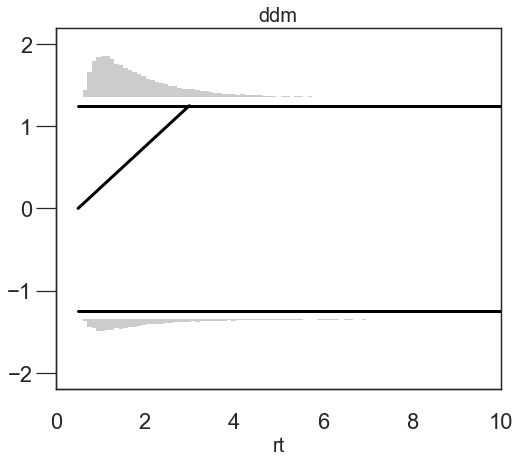

In [192]:
bgn_boundary_posterior_plot(params = [0.5, 1.25, 0.5, 0.5],
                            model = 'ddm',
                            max_t = 10,
                            show = True,
                            save = False)

p up:  0.7489
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.64387769e-03 1.77800774e-01 5.55875284e-01
 7.58792896e-01 8.24228869e-01 7.89197490e-01 7.44912538e-01
 7.01949526e-01 6.00821204e-01 5.23487782e-01 4.54085993e-01
 3.89310989e-01 3.45026038e-01 3.31145680e-01 2.82894913e-01
 2.65048738e-01 2.28695420e-01 1.97629857e-01 1.81766591e-01
 1.82427560e-01 1.44091334e-01 1.16991588e-01 1.20957404e-01
 1.02450260e-01 9.78234744e-02 6.87408199e-02 6.21311257e-02
 7.00627587e-02 6.54359728e-02 4.23020430e-02 6.08091868e-02
 4.09801042e-02 4.29630124e-02 3.43704099e-02 3.96581653e-02
 3.30484711e-02 2.90826546e-02 1.65242355e-02 2.04900521e-02
 2.11510215e-02 9.25357191e-03 1.32193884e-02 1.85071438e-02
 1.18974496e-02 8.59260248e-03 7.93163306e-03 7.93163306e-03
 2.64387769e-03 7.27066364e-03 7.27066364e-03 2.64387769e-03
 3.30484711e-03 1.32193884e-03 3.96581653e-03 1.98290827e-03
 1.32193884e-03 2.64387769e-03 1.32193884e-03 4.62678595e-03
 1.9829082

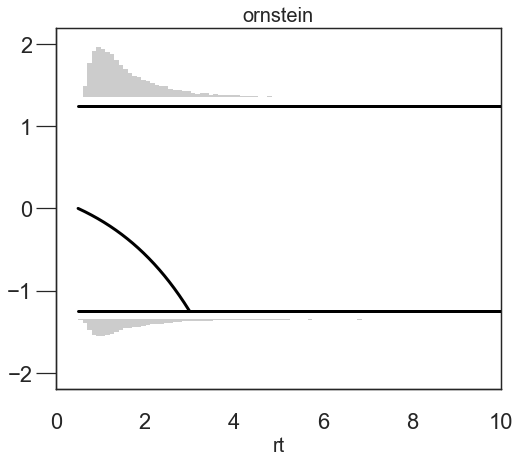

In [188]:
bgn_boundary_posterior_plot(params = [0.5, 1.25, 0.5, -0.5, 0.5],
                            model = 'ornstein',
                            max_t = 10,
                            show = True,
                            save = False)

In [ ]:
 hist_arr, bins_arr = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0], 
                            bins = np.linspace(0, 10, 100),
                            density = True)
    ax_tmp.hist(hist_arr / 10, 
                bins = bins_arr, 
                density = False, 
                alpha = 0.2,
                color = 'black',
                edgecolor='none',
                zorder = -1)

In [127]:
a, b = np.histogram(np.random.uniform(size = 1000, high = 10, low = 0),
                    np.linspace(0, 10, 100),
                    density = True)

In [131]:
a, b = np.histogram(np.random.uniform(size = 1000, high = 10, low = 0),
                    density = True)

(array([0.594 , 1.1979, 1.089 , 0.8316, 0.693 , 0.9009, 1.0296, 0.2376,
        0.594 , 0.3168, 1.3068, 0.8019, 0.9702, 0.4851, 0.8712, 0.8316,
        0.4752, 1.0692, 1.1979, 0.7128, 0.5544, 0.9801, 0.792 , 1.089 ,
        0.7128, 0.7128, 1.089 , 1.3365, 1.287 , 0.4158, 0.3564, 1.386 ,
        0.4752, 1.1583, 0.6237, 0.693 , 1.287 , 0.6336, 1.089 , 2.0196,
        1.5048, 1.8018, 1.4157, 0.9504, 1.287 , 0.4455, 1.8018, 1.683 ,
        0.2376, 1.3464, 0.792 , 0.99  , 0.3564, 1.2474, 2.079 , 2.1879,
        0.6534, 0.3564, 1.9305, 1.3068, 0.7128, 0.7623, 1.386 , 1.1583,
        1.584 , 1.188 , 0.594 , 0.8019, 2.1384, 1.683 , 1.0692, 0.4455,
        0.7623, 1.089 , 0.4158, 1.6335, 1.188 , 0.7128, 1.089 , 0.792 ,
        1.386 , 0.693 , 1.0395, 1.1088, 0.3564, 1.3068, 1.188 , 1.1979,
        1.1583, 1.0296, 1.6731, 0.9504, 1.0395, 0.594 , 0.9801, 1.0692,
        1.9602, 0.6336, 0.792 ]),
 array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
         0.50505051,  0.60606

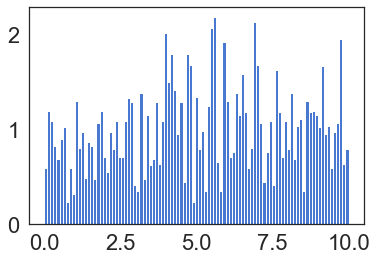

In [147]:
counts, bins = np.histogram(np.random.uniform(size = 1000, 
                                              high = 10, 
                                              low = 0), 
                            bins  = np.linspace(0, 10, 100))
counts_2, bins = np.histogram(np.random.uniform(size = 1000, 
                                              high = 10, 
                                              low = 0), 
                                bins  = np.linspace(0, 10, 100),
                            density = True)
plt.hist(bins[:-1], bins, weights = counts * counts_2)

array([0.0891, 0.0495, 0.1287, 0.0792, 0.1089, 0.1089, 0.1188, 0.1584,
       0.0693, 0.0693, 0.0594, 0.099 , 0.0495, 0.0891, 0.1188, 0.0693,
       0.1287, 0.0594, 0.0891, 0.0792, 0.1485, 0.0495, 0.0891, 0.1287,
       0.099 , 0.0891, 0.0891, 0.0594, 0.1089, 0.1386, 0.0594, 0.0891,
       0.099 , 0.1386, 0.0495, 0.0693, 0.1485, 0.1287, 0.1683, 0.1386,
       0.0792, 0.099 , 0.1485, 0.1188, 0.0891, 0.1089, 0.1485, 0.0891,
       0.1089, 0.1584, 0.1188, 0.1287, 0.1584, 0.1287, 0.1287, 0.0891,
       0.0891, 0.0396, 0.0693, 0.1188, 0.1683, 0.099 , 0.0297, 0.0495,
       0.099 , 0.0297, 0.0792, 0.1287, 0.0594, 0.0792, 0.1188, 0.1188,
       0.1386, 0.1089, 0.0792, 0.0693, 0.099 , 0.0792, 0.1188, 0.0495,
       0.1386, 0.0594, 0.099 , 0.1188, 0.1188, 0.0891, 0.099 , 0.1683,
       0.0594, 0.0792, 0.1089, 0.099 , 0.1188, 0.1287, 0.0891, 0.0594,
       0.0891, 0.1188, 0.1287])

In [129]:
np.linspace(0, 10, 100)

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96